In [2]:
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import os
from google.cloud import storage

%load_ext google.cloud.bigquery

In [3]:
demoDf = pd.read_csv('./data/us_demography.csv')
demoDf.head()

,FIPS,State_FIP,State,StateName,County,Urban,Population,Frac65Plus,PopDensity
0,1001,1,AL,Alabama,Autauga County,2.0,55601,0.155627,93.534462
1,1003,1,AL,Alabama,Baldwin County,3.0,218022,0.204433,137.136021
2,1005,1,AL,Alabama,Barbour County,6.0,24881,0.194204,28.113870
3,1007,1,AL,Alabama,Bibb County,1.0,22400,0.164732,35.986190
4,1009,1,AL,Alabama,Blount County,1.0,57840,0.182365,89.697921


In [4]:
stateDemoDf = demoDf.copy()
stateDemoDf["elderlyPop"] = stateDemoDf[["Population", "Frac65Plus"]].apply(lambda x: x[0]*x[1], axis=1)
stateDemoDf["landArea"] = stateDemoDf[["Population", "PopDensity"]].apply(lambda x: x[0]/x[1], axis=1)
stateDemoDf = stateDemoDf.groupby(["State_FIP", "State", "StateName"]).agg({"Urban":"median",
                                                              "Population":"sum",
                                                              "elderlyPop":"sum",
                                                              "landArea":"sum"
                                                             }).reset_index()
stateDemoDf["Frac65Plus"] = stateDemoDf[["Population", "elderlyPop"]].apply(lambda x: x[1]/x[0], axis=1)
stateDemoDf["PopDensity"] = stateDemoDf[["Population", "landArea"]].apply(lambda x: x[0]/x[1], axis=1)
stateDemoDf.head()

,State_FIP,State,StateName,Urban,Population,elderlyPop,landArea,Frac65Plus,PopDensity
0,1,AL,Alabama,4.0,4887871,826894.0,50646.639,0.169173,96.509287
1,2,AK,Alaska,9.0,737438,87011.0,571016.948,0.117991,1.291447
2,4,AZ,Arizona,3.0,7171646,1258250.0,113653.146,0.175448,63.101166
3,5,AR,Arkansas,6.0,3013825,511827.0,52037.528,0.169826,57.916375
4,6,CA,California,2.5,39557045,5669025.0,155854.041,0.143313,253.808273


## Using Google Big Query to get cases data

- There is mixture of data granularity

In [5]:
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'project-key.json'

In [52]:
%%bigquery earlyDf

SELECT * FROM `bigquery-public-data.covid19_jhu_csse.summary`
WHERE  country_region = 'US'
AND confirmed > 0
AND province_state LIKE '%County%'
ORDER BY date

In [53]:
# earlyDf = pd.read_csv("./data/cases_early_counties.csv")
error_raw_states = set()
def clean_early(row):
    raw_state = row["province_state"]
    raw_state = raw_state.strip()
    county, state = raw_state.split(",")
    county = county.strip()
    state = state.strip()
    lookupDf = demoDf[(demoDf["County"] == county) & (demoDf["State"] == state)]
    if lookupDf.shape[0] == 1:
        lookup = lookupDf.iloc[0]
    else:
        print("Error for :", raw_state)
        error_raw_states.add(raw_state)
        return row
    row["admin2"] = lookup["County"].replace("County", "").strip()
    row["fips"] = lookup["FIPS"]
    row["province_state"] = lookup["StateName"]
    return row
earlyDf = earlyDf.apply(lambda row: clean_early(row), axis=1)
earlyDf = earlyDf[~earlyDf["province_state"].isin(error_raw_states)]
earlyDf["fips"] = earlyDf["fips"].astype('int64')
demoFeatures = ["FIPS", "State_FIP", "State", "Urban", "Population", "Frac65Plus", "PopDensity"]
earlyDf = earlyDf.merge(demoDf[demoFeatures], left_on="fips", right_on="FIPS", how="left")
earlyDf = earlyDf.drop("FIPS", axis=1)
print(earlyDf.shape)
earlyDf.head()

Error for : Norwell County, MA
(404, 19)


,province_state,country_region,date,latitude,longitude,location_geom,confirmed,deaths,recovered,active,fips,admin2,combined_key,State_FIP,State,Urban,Population,Frac65Plus,PopDensity
0,California,US,2020-02-11,NaN,NaN,None,1,0,0,None,6073,San Diego,None,6,CA,1.0,3343364,0.140414,794.110116
1,California,US,2020-02-12,NaN,NaN,None,1,0,0,None,6073,San Diego,None,6,CA,1.0,3343364,0.140414,794.110116
2,California,US,2020-02-13,NaN,NaN,None,2,0,0,None,6073,San Diego,None,6,CA,1.0,3343364,0.140414,794.110116
3,California,US,2020-02-14,NaN,NaN,None,2,0,0,None,6073,San Diego,None,6,CA,1.0,3343364,0.140414,794.110116
4,California,US,2020-02-15,NaN,NaN,None,2,0,0,None,6073,San Diego,None,6,CA,1.0,3343364,0.140414,794.110116


In [54]:
%%bigquery midDf
SELECT * FROM `bigquery-public-data.covid19_jhu_csse.summary`
WHERE  country_region = 'US'
AND confirmed > 0
AND date >= '2020-03-09' AND date <='2020-03-22'
AND fips is NULL AND admin2 is NULL
AND NOT province_state LIKE '%County%'
ORDER BY date

In [55]:
# midDf = pd.read_csv("./data/cases_mar10_mar22_states.csv")
demoSFeatures = ["State_FIP", "State", "StateName", "Urban", "Population", "Frac65Plus", "PopDensity"]
midDf = midDf.merge(stateDemoDf[demoSFeatures], left_on="province_state", right_on="StateName", how="inner")
midDf["fips"] = midDf["State_FIP"]
midDf = midDf.drop(["StateName"], axis=1)
print(midDf.shape)
midDf.tail()

(589, 19)


,province_state,country_region,date,latitude,longitude,location_geom,confirmed,deaths,recovered,active,fips,admin2,combined_key,State_FIP,State,Urban,Population,Frac65Plus,PopDensity
584,West Virginia,US,2020-03-17,38.4912,-80.9545,POINT(-80.9545 38.4912),1,0,0,NaN,54,None,None,54,WV,6.0,1805832,0.199287,75.114279
585,West Virginia,US,2020-03-18,38.4912,-80.9545,POINT(-80.9545 38.4912),1,0,0,NaN,54,None,None,54,WV,6.0,1805832,0.199287,75.114279
586,West Virginia,US,2020-03-19,38.4912,-80.9545,POINT(-80.9545 38.4912),2,0,0,NaN,54,None,None,54,WV,6.0,1805832,0.199287,75.114279
587,West Virginia,US,2020-03-20,38.4912,-80.9545,POINT(-80.9545 38.4912),7,0,0,NaN,54,None,None,54,WV,6.0,1805832,0.199287,75.114279
588,West Virginia,US,2020-03-21,38.4912,-80.9545,POINT(-80.9545 38.4912),8,0,0,NaN,54,None,None,54,WV,6.0,1805832,0.199287,75.114279


In [56]:
midStart = midDf.groupby("province_state")["date"].min().reset_index()
midStart = midStart.rename(columns={"date":"date1"})
earlyStart = earlyDf.groupby(["province_state"])["date"].min().reset_index()
approxStart = stateDemoDf[["State_FIP", "State", "StateName"]].merge(earlyStart, left_on="StateName", right_on="province_state", how="left", )
approxStart = approxStart.merge(midStart, left_on="StateName", right_on="province_state", how="left")
def approx_startdate(dateEarly, dateMid):
    if pd.isnull(dateEarly):
        return dateMid
    else:
        return dateEarly
approxStart["startDate"] = approxStart[["date", "date1"]].apply(lambda x: approx_startdate(x[0], x[1]), axis=1)
approxStart = approxStart.drop(["province_state_x", "province_state_y", "date1", "date"], axis=1)
approxStart.tail()

,State_FIP,State,StateName,startDate
47,53,WA,Washington,2020-02-29
48,54,WV,West Virginia,2020-03-17
49,55,WI,Wisconsin,2020-03-10
50,56,WY,Wyoming,2020-03-12
51,72,PR,Puerto Rico,2020-03-14


In [152]:
%%bigquery casesDf

SELECT * FROM `bigquery-public-data.covid19_jhu_csse_eu.summary`
WHERE  country_region = 'US'
AND fips is not NULL
AND confirmed > 0
ORDER BY date;

In [153]:
casesDf["fips"] = casesDf["fips"].astype("int64")
demoFeatures = ["FIPS", "State_FIP", "State", "Urban", "Population", "Frac65Plus", "PopDensity"]
combinedDf = casesDf.merge(demoDf[demoFeatures], left_on="fips", right_on="FIPS", how="inner")
combinedDf = combinedDf.drop("FIPS", axis=1)
combinedDf.head()

,province_state,country_region,date,latitude,longitude,location_geom,confirmed,deaths,recovered,active,fips,admin2,combined_key,State_FIP,State,Urban,Population,Frac65Plus,PopDensity
0,Iowa,US,2020-03-22,42.079231,-91.598095,POINT(-91.59809485 42.07923082),4,0,0,0,19113,Linn,"Linn, Iowa, US",19,IA,2.0,225909,0.158037,315.041042
1,Iowa,US,2020-03-23,42.079231,-91.598095,POINT(-91.59809485 42.07923082),6,0,0,0,19113,Linn,"Linn, Iowa, US",19,IA,2.0,225909,0.158037,315.041042
2,Iowa,US,2020-03-24,42.079231,-91.598095,POINT(-91.59809485 42.07923082),6,0,0,0,19113,Linn,"Linn, Iowa, US",19,IA,2.0,225909,0.158037,315.041042
3,Iowa,US,2020-03-25,42.079231,-91.598095,POINT(-91.59809485 42.07923082),7,0,0,0,19113,Linn,"Linn, Iowa, US",19,IA,2.0,225909,0.158037,315.041042
4,Iowa,US,2020-03-26,42.079231,-91.598095,POINT(-91.59809485 42.07923082),12,0,0,0,19113,Linn,"Linn, Iowa, US",19,IA,2.0,225909,0.158037,315.041042


In [154]:
prDf = casesDf[casesDf["admin2"].isna()].merge(demoDf[demoFeatures], left_on="fips", right_on="State_FIP", how="inner")
prDf = prDf.drop("FIPS", axis=1)
casesDemoDf = pd.concat([earlyDf, midDf, combinedDf, prDf], sort=False)
casesDemoDf = casesDemoDf.merge(approxStart[["State_FIP", "startDate"]], on="State_FIP", how="left")
casesDemoDf["startDate"].isna().sum()

0

In [155]:
print(prDf.shape)
casesDemoDf.head()

(2418, 19)


,province_state,country_region,date,latitude,longitude,location_geom,confirmed,deaths,recovered,active,fips,admin2,combined_key,State_FIP,State,Urban,Population,Frac65Plus,PopDensity,startDate
0,California,US,2020-02-11,NaN,NaN,None,1,0,0,None,6073,San Diego,None,6,CA,1.0,3343364,0.140414,794.110116,2020-02-11
1,California,US,2020-02-12,NaN,NaN,None,1,0,0,None,6073,San Diego,None,6,CA,1.0,3343364,0.140414,794.110116,2020-02-11
2,California,US,2020-02-13,NaN,NaN,None,2,0,0,None,6073,San Diego,None,6,CA,1.0,3343364,0.140414,794.110116,2020-02-11
3,California,US,2020-02-14,NaN,NaN,None,2,0,0,None,6073,San Diego,None,6,CA,1.0,3343364,0.140414,794.110116,2020-02-11
4,California,US,2020-02-15,NaN,NaN,None,2,0,0,None,6073,San Diego,None,6,CA,1.0,3343364,0.140414,794.110116,2020-02-11


In [156]:
casesDemoDf["date"] = pd.to_datetime(casesDemoDf["date"])
casesDemoDf["startDate"] = pd.to_datetime(casesDemoDf["startDate"])
casesDemoDf["approxDays"] = (casesDemoDf["date"] - casesDemoDf["startDate"]).dt.days + 1
casesDemoDf["approxDays"] = casesDemoDf["approxDays"].astype('int64')
casesDemoDf.head()

,province_state,country_region,date,latitude,longitude,location_geom,confirmed,deaths,recovered,active,...,admin2,combined_key,State_FIP,State,Urban,Population,Frac65Plus,PopDensity,startDate,approxDays
0,California,US,2020-02-11,NaN,NaN,None,1,0,0,None,...,San Diego,None,6,CA,1.0,3343364,0.140414,794.110116,2020-02-11,1
1,California,US,2020-02-12,NaN,NaN,None,1,0,0,None,...,San Diego,None,6,CA,1.0,3343364,0.140414,794.110116,2020-02-11,2
2,California,US,2020-02-13,NaN,NaN,None,2,0,0,None,...,San Diego,None,6,CA,1.0,3343364,0.140414,794.110116,2020-02-11,3
3,California,US,2020-02-14,NaN,NaN,None,2,0,0,None,...,San Diego,None,6,CA,1.0,3343364,0.140414,794.110116,2020-02-11,4
4,California,US,2020-02-15,NaN,NaN,None,2,0,0,None,...,San Diego,None,6,CA,1.0,3343364,0.140414,794.110116,2020-02-11,5


In [157]:
casesDemoDf['casesPer1M'] = casesDemoDf[["Population", "confirmed"]].apply(lambda x: x[1]*1e6/x[0], axis=1).astype('float64')
casesDemoDf.head()

,province_state,country_region,date,latitude,longitude,location_geom,confirmed,deaths,recovered,active,...,combined_key,State_FIP,State,Urban,Population,Frac65Plus,PopDensity,startDate,approxDays,casesPer1M
0,California,US,2020-02-11,NaN,NaN,None,1,0,0,None,...,None,6,CA,1.0,3343364,0.140414,794.110116,2020-02-11,1,0.2991
1,California,US,2020-02-12,NaN,NaN,None,1,0,0,None,...,None,6,CA,1.0,3343364,0.140414,794.110116,2020-02-11,2,0.2991
2,California,US,2020-02-13,NaN,NaN,None,2,0,0,None,...,None,6,CA,1.0,3343364,0.140414,794.110116,2020-02-11,3,0.5982
3,California,US,2020-02-14,NaN,NaN,None,2,0,0,None,...,None,6,CA,1.0,3343364,0.140414,794.110116,2020-02-11,4,0.5982
4,California,US,2020-02-15,NaN,NaN,None,2,0,0,None,...,None,6,CA,1.0,3343364,0.140414,794.110116,2020-02-11,5,0.5982


### Adding Interventions information

In [158]:
# cleaned data from https://github.com/Keystone-Strategy/covid19-intervention-data
intDf = pd.read_csv("./data/npis_lookup.csv")
intCols = intDf.columns.values
print(intDf.shape)
print(intCols)
intDf.head()

(384, 12)
['fip_code' 'gathering_size_500_to_101' 'gathering_size_100_to_26'
 'gathering_size_25_to_11' 'gathering_size_10_0' 'school_closure'
 'closing_of_public_venues' 'non-essential_services_closure'
 'social_distancing' 'shelter_in_place' 'religious_gatherings_banned'
 'lockdown']


,fip_code,gathering_size_500_to_101,gathering_size_100_to_26,gathering_size_25_to_11,gathering_size_10_0,school_closure,closing_of_public_venues,non-essential_services_closure,social_distancing,shelter_in_place,religious_gatherings_banned,lockdown
0,1,2020-03-13,2020-03-16,2020-03-19,2020-03-28,2020-03-20,2020-03-28,2020-03-28,2020-04-03,2020-04-04,2020-04-04,NaN
1,2,2020-03-24,2020-03-24,2020-03-24,2020-03-24,2020-03-16,2020-03-18,2020-03-28,2020-03-28,2020-03-28,2020-03-24,NaN
2,4,NaN,NaN,NaN,NaN,2020-03-15,2020-03-31,2020-03-31,2020-03-31,2020-03-31,NaN,NaN
3,5,2020-03-27,2020-03-27,2020-03-27,2020-03-27,2020-03-19,2020-03-20,2020-04-06,2020-03-27,NaN,NaN,NaN
4,6,2020-03-11,2020-03-16,2020-03-16,2020-03-16,2020-03-19,2020-03-19,2020-03-19,2020-03-19,2020-03-19,2020-03-19,NaN


In [159]:
caseIntCountiesDf = casesDemoDf.merge(intDf, left_on="fips", right_on="fip_code", how="left")
caseIntStatesDf = caseIntCountiesDf[caseIntCountiesDf['fip_code'].isna()]
caseIntCountiesDf = caseIntCountiesDf[~caseIntCountiesDf['fip_code'].isna()]
caseIntStatesDf = caseIntStatesDf.drop(intCols, axis=1)
caseIntStatesDf = caseIntStatesDf.merge(intDf, left_on="State_FIP", right_on="fip_code", how="left")
caseIntDemoDf = pd.concat([caseIntStatesDf,caseIntCountiesDf], sort=False)
print(caseIntDemoDf.shape)
caseIntDemoDf.sample(5)

(103987, 34)


,province_state,country_region,date,latitude,longitude,location_geom,confirmed,deaths,recovered,active,...,gathering_size_100_to_26,gathering_size_25_to_11,gathering_size_10_0,school_closure,closing_of_public_venues,non-essential_services_closure,social_distancing,shelter_in_place,religious_gatherings_banned,lockdown
61700,Georgia,US,2020-04-01,31.554565,-82.459365,POINT(-82.45936528 31.55456473),6,0,0,0,...,2020-03-24,2020-03-24,2020-03-24,2020-03-18,2020-03-24,2020-04-03,2020-03-24,2020-04-03,NaN,NaN
3686,Ohio,US,2020-03-27,39.753949,-84.290510,POINT(-84.29050975 39.75394919),19,0,0,0,...,2020-03-12,NaN,NaN,2020-03-17,2020-03-15,2020-03-19,2020-03-23,2020-03-23,NaN,NaN
49544,Alabama,US,2020-04-20,31.399328,-85.989010,POINT(-85.98901039 31.39932826),64,0,0,64,...,2020-03-16,2020-03-19,2020-03-28,2020-03-20,2020-03-28,2020-03-28,2020-04-03,2020-04-04,2020-04-04,NaN
28658,Virginia,US,2020-04-23,38.876767,-77.101399,POINT(-77.10139853 38.8767675),686,24,0,662,...,2020-03-15,2020-03-17,2020-03-17,2020-03-13,2020-03-24,2020-03-24,2020-03-24,2020-03-30,2020-03-24,NaN
31578,North Carolina,US,2020-04-21,35.367319,-78.872436,POINT(-78.87243571 35.36731853),62,5,0,57,...,2020-03-14,2020-03-30,2020-03-30,2020-03-16,2020-03-17,2020-03-30,2020-03-14,2020-03-30,2020-03-30,NaN


In [160]:
def encode_intervention_info(row):
    date = row["date"]
    total_int = 0
    for col in intCols[1:]:
        intDate = row[col]
        if pd.isnull(intDate) or intDate > str(date):
            row[col] = 0
        else:
            row[col] = 1
            total_int += 1
    row["totalInt"] = total_int
    return row

caseIntDemoDf = caseIntDemoDf.apply(lambda row: encode_intervention_info(row), axis=1)

In [161]:
caseIntDemoDf.sample(5)

,province_state,country_region,date,latitude,longitude,location_geom,confirmed,deaths,recovered,active,...,gathering_size_25_to_11,gathering_size_10_0,school_closure,closing_of_public_venues,non-essential_services_closure,social_distancing,shelter_in_place,religious_gatherings_banned,lockdown,totalInt
81781,Illinois,US,2020-04-12,39.391335,-88.806111,POINT(-88.80611122 39.39133527),4,0,0,4.0,...,1,1,1,1,1,1,1,1,0,10
34031,Texas,US,2020-04-18,31.253506,-96.936301,POINT(-96.93630086 31.25350609),1,0,0,1.0,...,1,1,1,1,1,1,0,0,0,8
57207,Ohio,US,2020-04-20,40.772852,-84.108023,POINT(-84.10802343 40.77285242),84,11,0,73.0,...,0,0,1,1,1,1,1,0,0,7
26359,Washington,US,2020-04-19,46.190747,-122.678223,POINT(-122.6782231 46.19074721),29,0,0,29.0,...,1,1,1,1,1,0,1,1,0,9
60603,Pennsylvania,US,2020-04-27,41.192658,-79.424135,POINT(-79.42413524 41.19265812),22,1,0,21.0,...,0,0,1,1,1,0,1,1,0,5


In [162]:
# Number of data records with no interventions
caseIntDemoDf[caseIntDemoDf['totalInt']==0].shape

(670, 35)

### Adding International Flights Info

In [163]:
# Cleaned data from https://opensky-network.org/datasets/covid-19/
# Only available upto 31 March. Considering 0 for missing data as there are not much flights
flightsDf = pd.read_csv("./data/aggregatedFlights.csv")
flightsDf = flightsDf.merge(stateDemoDf[["State_FIP", "State"]], left_on="state_abbreviation", right_on="State", how="left")
flightsDf = flightsDf.rename(columns={'destination':'flights'})
flightsDf.head()

,state_abbreviation,week,day,flights,State_FIP,State
0,AK,1,2020-01-01,100,2,AK
1,AK,2,2020-01-06,148,2,AK
2,AK,3,2020-01-13,160,2,AK
3,AK,4,2020-01-20,120,2,AK
4,AK,5,2020-01-27,77,2,AK


In [164]:
caseIntDemoDf["week"] = caseIntDemoDf["date"].dt.week - 1
caseIntDemoDf.head()

,province_state,country_region,date,latitude,longitude,location_geom,confirmed,deaths,recovered,active,...,gathering_size_10_0,school_closure,closing_of_public_venues,non-essential_services_closure,social_distancing,shelter_in_place,religious_gatherings_banned,lockdown,totalInt,week
0,California,US,2020-02-21,NaN,NaN,None,1,0,0,NaN,...,0,0,0,0,0,0,0,0,0,7
1,California,US,2020-02-22,NaN,NaN,None,1,0,0,NaN,...,0,0,0,0,0,0,0,0,0,7
2,California,US,2020-02-23,NaN,NaN,None,1,0,0,NaN,...,0,0,0,0,0,0,0,0,0,7
3,California,US,2020-02-24,NaN,NaN,None,1,0,0,NaN,...,0,0,0,0,0,0,0,0,0,8
4,California,US,2020-02-25,NaN,NaN,None,1,0,0,NaN,...,0,0,0,0,0,0,0,0,0,8


In [165]:
caseIntDemoDf = caseIntDemoDf.merge(flightsDf[["State_FIP", "week", "flights"]], on=["State_FIP", "week"], how="left")
caseIntDemoDf["flights"] = caseIntDemoDf["flights"].fillna(0.0)
caseIntDemoDf = caseIntDemoDf.rename(columns = {"flights": "flights_prev_week"})
caseIntDemoDf.head()

,province_state,country_region,date,latitude,longitude,location_geom,confirmed,deaths,recovered,active,...,school_closure,closing_of_public_venues,non-essential_services_closure,social_distancing,shelter_in_place,religious_gatherings_banned,lockdown,totalInt,week,flights_prev_week
0,California,US,2020-02-21,NaN,NaN,None,1,0,0,NaN,...,0,0,0,0,0,0,0,0,7,774.0
1,California,US,2020-02-22,NaN,NaN,None,1,0,0,NaN,...,0,0,0,0,0,0,0,0,7,774.0
2,California,US,2020-02-23,NaN,NaN,None,1,0,0,NaN,...,0,0,0,0,0,0,0,0,7,774.0
3,California,US,2020-02-24,NaN,NaN,None,1,0,0,NaN,...,0,0,0,0,0,0,0,0,8,854.0
4,California,US,2020-02-25,NaN,NaN,None,1,0,0,NaN,...,0,0,0,0,0,0,0,0,8,854.0


### Adding climatic information

In [166]:
%%bigquery tempDf

SELECT date, state, AVG(data.value) as tavg FROM `bigquery-public-data.ghcn_d.ghcnd_2020` as data
INNER JOIN (
SELECT st.id as stId, st.state as state FROM `bigquery-public-data.ghcn_d.ghcnd_stations` st
WHERE st.state in ( SELECT code FROM  `bigquery-public-data.ghcn_d.ghcnd_states`)
-- AND st.id LIKE 'US%'
) as us_st
ON data.id = us_st.stId 
WHERE data.element = 'TMAX'
GROUP BY date, state
ORDER BY date,state

In [167]:
tempDf["tavg"] = tempDf["tavg"]/10
tempDf = tempDf.merge(stateDemoDf[["State_FIP", "State"]], left_on="state", right_on="State", how="inner")
tempDf.head()

,date,state,tavg,State_FIP,State
0,2020-01-01,AK,-9.392131,2,AK
1,2020-01-02,AK,-14.129373,2,AK
2,2020-01-03,AK,-16.310299,2,AK
3,2020-01-04,AK,-18.741860,2,AK
4,2020-01-05,AK,-19.888926,2,AK


In [168]:
tempDf["date"] = pd.to_datetime(tempDf["date"])
tempDf["week"] = tempDf["date"].dt.week
tempDf.sample(10)

,date,state,tavg,State_FIP,State,week
2294,2020-04-09,MA,11.002000,25,MA,15
2595,2020-02-04,MI,3.748087,26,MI,6
2492,2020-02-23,ME,4.928070,23,ME,8
3537,2020-01-01,NH,1.034783,33,NH,1
4217,2020-03-11,OH,11.609195,39,OH,11
3483,2020-03-09,NE,18.403101,31,NE,11
231,2020-04-19,AL,20.172500,1,AL,16
434,2020-03-09,AZ,16.564894,4,AZ,11
4798,2020-02-11,RI,7.060000,44,RI,7
1296,2020-03-18,HI,23.762791,15,HI,12


In [169]:
aggTempDf = tempDf.groupby(["week", "State_FIP", "state"])["tavg"].mean().reset_index()
aggTempDf.tail()

,week,State_FIP,state,tavg
913,18,53,WA,15.112661
914,18,54,WV,17.201241
915,18,55,WI,14.973213
916,18,56,WY,17.419099
917,18,72,PR,30.239662


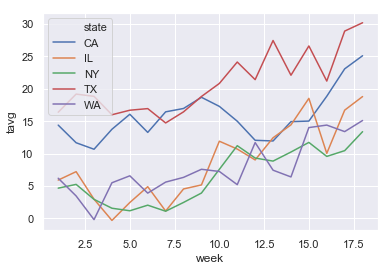

In [170]:
sns.lineplot(x="week", y="tavg", data=aggTempDf[aggTempDf["state"].isin(["NY", "WA", "IL", "CA", "TX"])], hue="state")

In [171]:
casesAllDf = caseIntDemoDf.merge(aggTempDf[["State_FIP","state", "week", "tavg"]], on=["week", "State_FIP"], how="left")
casesAllDf = casesAllDf.rename(columns={"tavg":"avg_temp_prev_week"})
casesAllDf.head()

,province_state,country_region,date,latitude,longitude,location_geom,confirmed,deaths,recovered,active,...,non-essential_services_closure,social_distancing,shelter_in_place,religious_gatherings_banned,lockdown,totalInt,week,flights_prev_week,state,avg_temp_prev_week
0,California,US,2020-02-21,NaN,NaN,None,1,0,0,NaN,...,0,0,0,0,0,0,7,774.0,CA,16.449679
1,California,US,2020-02-22,NaN,NaN,None,1,0,0,NaN,...,0,0,0,0,0,0,7,774.0,CA,16.449679
2,California,US,2020-02-23,NaN,NaN,None,1,0,0,NaN,...,0,0,0,0,0,0,7,774.0,CA,16.449679
3,California,US,2020-02-24,NaN,NaN,None,1,0,0,NaN,...,0,0,0,0,0,0,8,854.0,CA,16.969811
4,California,US,2020-02-25,NaN,NaN,None,1,0,0,NaN,...,0,0,0,0,0,0,8,854.0,CA,16.969811


## Imputing missing temperature values using mean temperature that week

In [172]:
# casesAllDf[casesAllDf["avg_temp_prev_week"].isna()]
tempFillerDict = casesAllDf.groupby("week")["avg_temp_prev_week"].mean().to_dict()
casesAllDf["avg_temp_prev_week"] = casesAllDf[["week", "avg_temp_prev_week"]].apply(
    lambda x: tempFillerDict[x[0]] if pd.isnull(x[1]) else x[1], axis=1)
casesAllDf.tail(10)

,province_state,country_region,date,latitude,longitude,location_geom,confirmed,deaths,recovered,active,...,non-essential_services_closure,social_distancing,shelter_in_place,religious_gatherings_banned,lockdown,totalInt,week,flights_prev_week,state,avg_temp_prev_week
103977,Puerto Rico,US,2020-05-02,18.2208,-66.5901,POINT(-66.5901 18.2208),1757,95,0,1662.0,...,1,1,0,1,1,10,17,0.0,PR,29.95696
103978,Puerto Rico,US,2020-05-02,18.2208,-66.5901,POINT(-66.5901 18.2208),1757,95,0,1662.0,...,1,1,0,1,1,10,17,0.0,PR,29.95696
103979,Puerto Rico,US,2020-05-02,18.2208,-66.5901,POINT(-66.5901 18.2208),1757,95,0,1662.0,...,1,1,0,1,1,10,17,0.0,PR,29.95696
103980,Puerto Rico,US,2020-05-02,18.2208,-66.5901,POINT(-66.5901 18.2208),1757,95,0,1662.0,...,1,1,0,1,1,10,17,0.0,PR,29.95696
103981,Puerto Rico,US,2020-05-02,18.2208,-66.5901,POINT(-66.5901 18.2208),1757,95,0,1662.0,...,1,1,0,1,1,10,17,0.0,PR,29.95696
103982,Puerto Rico,US,2020-05-02,18.2208,-66.5901,POINT(-66.5901 18.2208),1757,95,0,1662.0,...,1,1,0,1,1,10,17,0.0,PR,29.95696
103983,Puerto Rico,US,2020-05-02,18.2208,-66.5901,POINT(-66.5901 18.2208),1757,95,0,1662.0,...,1,1,0,1,1,10,17,0.0,PR,29.95696
103984,Puerto Rico,US,2020-05-02,18.2208,-66.5901,POINT(-66.5901 18.2208),1757,95,0,1662.0,...,1,1,0,1,1,10,17,0.0,PR,29.95696
103985,Puerto Rico,US,2020-05-02,18.2208,-66.5901,POINT(-66.5901 18.2208),1757,95,0,1662.0,...,1,1,0,1,1,10,17,0.0,PR,29.95696
103986,Puerto Rico,US,2020-05-02,18.2208,-66.5901,POINT(-66.5901 18.2208),1757,95,0,1662.0,...,1,1,0,1,1,10,17,0.0,PR,29.95696


In [173]:
casesAllDf["state"] = casesAllDf["state"].fillna("DC")
casesAllDf.isna().sum()

province_state                       0
country_region                       0
date                                 0
latitude                            38
longitude                           38
location_geom                       38
confirmed                            0
deaths                               0
recovered                            0
active                             992
fips                                 0
admin2                            3007
combined_key                       992
State_FIP                            0
State                                0
Urban                                0
Population                           0
Frac65Plus                           0
PopDensity                           0
startDate                            0
approxDays                           0
casesPer1M                           0
fip_code                             0
gathering_size_500_to_101            0
gathering_size_100_to_26             0
gathering_size_25_to_11  

In [194]:
casesAllDf = casesAllDf[casesAllDf.fips != 72]

In [195]:
casesAllDf.columns

Index(['province_state', 'country_region', 'date', 'latitude', 'longitude',
       'location_geom', 'confirmed', 'deaths', 'recovered', 'active', 'fips',
       'admin2', 'combined_key', 'State_FIP', 'State', 'Urban', 'Population',
       'Frac65Plus', 'PopDensity', 'startDate', 'approxDays', 'casesPer1M',
       'fip_code', 'gathering_size_500_to_101', 'gathering_size_100_to_26',
       'gathering_size_25_to_11', 'gathering_size_10_0', 'school_closure',
       'closing_of_public_venues', 'non-essential_services_closure',
       'social_distancing', 'shelter_in_place', 'religious_gatherings_banned',
       'lockdown', 'totalInt', 'week', 'flights_prev_week', 'state',
       'avg_temp_prev_week'],
      dtype='object')

In [196]:
features = ['approxDays', 'Urban',
       'Frac65Plus', 'PopDensity', 'gathering_size_500_to_101', 'gathering_size_100_to_26',
       'gathering_size_25_to_11', 'gathering_size_10_0', 'school_closure',
       'closing_of_public_venues', 'non-essential_services_closure',
       'social_distancing', 'shelter_in_place', 'religious_gatherings_banned',
       'lockdown', 'flights_prev_week',
       'avg_temp_prev_week','casesPer1M']
featuresDf = casesAllDf[features]
featuresDf.head()

,approxDays,Urban,Frac65Plus,PopDensity,gathering_size_500_to_101,gathering_size_100_to_26,gathering_size_25_to_11,gathering_size_10_0,school_closure,closing_of_public_venues,non-essential_services_closure,social_distancing,shelter_in_place,religious_gatherings_banned,lockdown,flights_prev_week,avg_temp_prev_week,casesPer1M
0,11,5.0,0.178774,38.219686,0,0,0,0,0,0,0,0,0,0,0,774.0,16.449679,7.33283
1,12,5.0,0.178774,38.219686,0,0,0,0,0,0,0,0,0,0,0,774.0,16.449679,7.33283
2,13,5.0,0.178774,38.219686,0,0,0,0,0,0,0,0,0,0,0,774.0,16.449679,7.33283
3,14,5.0,0.178774,38.219686,0,0,0,0,0,0,0,0,0,0,0,854.0,16.969811,7.33283
4,15,5.0,0.178774,38.219686,0,0,0,0,0,0,0,0,0,0,0,854.0,16.969811,7.33283


In [197]:
featuresDf.to_csv("./data/us_covid19_features.csv", index=False)

In [198]:
casesAllDf.to_csv("./data/raw_us_covid19_features.csv", index=False)

In [199]:
integer_cols = ["approxDays", 'gathering_size_500_to_101', 'gathering_size_100_to_26',
       'gathering_size_25_to_11', 'gathering_size_10_0', 'school_closure',
       'closing_of_public_venues', 'non-essential_services_closure',
       'social_distancing', 'shelter_in_place', 'religious_gatherings_banned',
       'lockdown']
featuresDf[integer_cols] = featuresDf[integer_cols].astype('float64')

C:\Users\shish\AppData\Local\conda\conda\envs\nlp\lib\site-packages\pandas\core\frame.py:3140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [200]:
featuresDf.dtypes

approxDays                        float64
Urban                             float64
Frac65Plus                        float64
PopDensity                        float64
gathering_size_500_to_101         float64
gathering_size_100_to_26          float64
gathering_size_25_to_11           float64
gathering_size_10_0               float64
school_closure                    float64
closing_of_public_venues          float64
non-essential_services_closure    float64
social_distancing                 float64
shelter_in_place                  float64
religious_gatherings_banned       float64
lockdown                          float64
flights_prev_week                 float64
avg_temp_prev_week                float64
casesPer1M                        float64
dtype: object

In [201]:
featuresDf.to_csv("./data/us_covid19_features_float.csv", index=False)

In [202]:
casesFirst30Days = featuresDf[featuresDf["approxDays"] < 30]
casesFirst30Days.to_csv("./data/cases_first_30days.csv", index=False)


C:\Users\shish\AppData\Local\conda\conda\envs\nlp\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


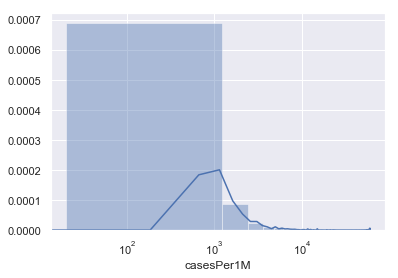

In [203]:
sns.distplot(featuresDf[featuresDf.approxDays==40]["casesPer1M"])
plt.xscale('log')

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


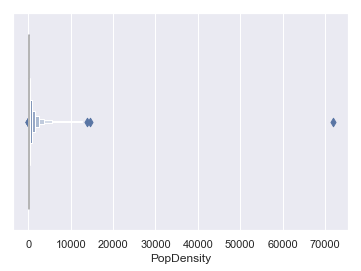

In [210]:
sns.boxenplot(featuresDf[featuresDf.approxDays==40]["PopDensity"])

In [193]:
casesAllDf["Urban"].value_counts()

6.0    19826
1.0    18752
2.0    15234
3.0    13852
7.0    12163
4.0     8498
9.0     6935
8.0     5099
5.0     3592
6.5       24
2.5       12
Name: Urban, dtype: int64

In [191]:
casesAllDf[casesAllDf.Urban ==9][["date", "approxDays", "casesPer1M", "PopDensity"]]

,date,approxDays,casesPer1M,PopDensity
2441,2020-03-22,10,1.718213e+02,25.919023
2442,2020-03-23,11,1.718213e+02,25.919023
2443,2020-03-24,12,1.718213e+02,25.919023
2444,2020-03-25,13,1.718213e+02,25.919023
2445,2020-03-26,14,1.718213e+02,25.919023
2446,2020-03-27,15,1.718213e+02,25.919023
2447,2020-03-28,16,1.718213e+02,25.919023
2448,2020-03-29,17,1.718213e+02,25.919023
2449,2020-03-30,18,1.718213e+02,25.919023
2450,2020-03-31,19,1.718213e+02,25.919023


In [190]:
data=casesAllDf[casesAllDf.fips==36061]
data[["date", "approxDays", "casesPer1M", "PopDensity"]]

,date,approxDays,casesPer1M,PopDensity
86872,2020-03-06,4,9.823780,71872.423988
86918,2020-03-07,5,6.753849,71872.423988
86983,2020-03-08,6,7.367835,71872.423988
87057,2020-03-09,7,11.665739,71872.423988
94852,2020-03-22,20,5927.423143,71872.423988
94853,2020-03-23,21,7555.100660,71872.423988
94854,2020-03-24,22,9150.850893,71872.423988
94855,2020-03-25,23,10963.338268,71872.423988
94856,2020-03-26,24,13429.720986,71872.423988
94857,2020-03-27,25,15701.470067,71872.423988


In [123]:
demoDf[demoDf.State == "NY"].sort_values(by="PopDensity", ascending=False)

,FIPS,State_FIP,State,StateName,County,Urban,Population,Frac65Plus,PopDensity
1858,36061,36,NY,New York,New York County,1.0,1628701,0.165102,71872.423988
1851,36047,36,NY,New York,Kings County,1.0,2582830,0.139090,37232.128699
1830,36005,36,NY,New York,Bronx County,1.0,1432132,0.128043,34057.835910
1868,36081,36,NY,New York,Queens County,1.0,2278906,0.156881,20950.063432
1870,36085,36,NY,New York,Richmond County,1.0,476179,0.161815,8278.494437
1857,36059,36,NY,New York,Nassau County,1.0,1358343,0.177630,4772.261122
1887,36119,36,NY,New York,Westchester County,1.0,967612,0.170531,2247.182348
1871,36087,36,NY,New York,Rockland County,1.0,325695,0.156917,1877.810705
1879,36103,36,NY,New York,Suffolk County,1.0,1481093,0.168630,1624.349232
1855,36055,36,NY,New York,Monroe County,1.0,742474,0.172463,1130.324510


In [211]:
from pandas import DataFrame
import statsmodels.api as sm
# making the fake dataset
data = { 
         'month': [12,11,10,9,8,7,6,5,4],
         'free_time': [120,110,100,90,80,85,60,50,40],
         'num_articles': [8,8,7,6,6,7,6,4,5]
       }
df = DataFrame(data, columns=['month', 'free_time', 'num_articles'])
# features
X = df[['free_time']] 
# target variable
Y = df['num_articles']
# adding a constant
X = sm.add_constant(X)
# applying method of least squares
model = sm.OLS(Y, X).fit()
predictions = model.predict(X)
print_model = model.summary()
print(print_model)

C:\Users\shish\AppData\Local\conda\conda\envs\nlp\lib\site-packages\scipy\stats\stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  "anyway, n=%i" % int(n))


                            OLS Regression Results                            
Dep. Variable:           num_articles   R-squared:                       0.818
Model:                            OLS   Adj. R-squared:                  0.792
Method:                 Least Squares   F-statistic:                     31.55
Date:                Sun, 03 May 2020   Prob (F-statistic):           0.000802
Time:                        20:29:10   Log-Likelihood:                -7.0819
No. Observations:                   9   AIC:                             18.16
Df Residuals:                       7   BIC:                             18.56
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.7345      0.672      4.072      0.0